### Process data stored in Google sheets, to get a few consolidated dataframes

In [1]:
# autoreload magic
%reload_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time


import time

from mindreadingautobots.analysis.analysis_config import SPREADSHEET_NAMES, BF_VALS, NAME_TEMPLATES, DATASET_NAMES
from mindreadingautobots.analysis.analysis_config import spreadsheet_to_dataframe

In [73]:
not_done = [] # these refer to indices of SPREADSHEET_NAMES
for i in not_done:
    SPREADSHEET_NAME = SPREADSHEET_NAMES[i]
    bf_vals = BF_VALS[i]
    sheetname_template = NAME_TEMPLATES[i]
    df = spreadsheet_to_dataframe(SPREADSHEET_NAME, bf_vals, sheetname_template)
    df.to_csv(f"./processed/{SPREADSHEET_NAME}.csv", index=False)

Loading: RNN_hamilton_6_choose_6_nbits11_n5000_bf0_seed1234_results
Loading: RNN_hamilton_6_choose_6_nbits11_n5000_bf10_seed1234_results
Loading: RNN_hamilton_6_choose_6_nbits11_n5000_bf20_seed1234_results
Loading: SAN_hamilton_6_choose_6_nbits11_n5000_bf0_seed1234_results
Loading: SAN_hamilton_6_choose_6_nbits11_n5000_bf10_seed1234_results
Loading: SAN_hamilton_6_choose_6_nbits11_n5000_bf20_seed1234_results


### Compute maximum likelihood, entropies

In [80]:
n_data = 100000 # ~maximum~ amount of data to analyze for estimating MLD
seed = 1234 
inc = 50000 # increment at which to check convergence
intermediate_idx = list(range(inc, n_data, inc))


def sparse_majority_k(k):
    def generator(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
        # for any sparse majority (n, k)
        return make_datasets.sparse_majority_k_n(n_bits, k, n_data, p_bitflip, seed, subseq_idx=subseq_idx)
    return generator

def sparity_k4(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_parity_k_n(n_bits, 4, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

def hamilton_6_choose_6(n_data, n_bits, p_bitflip, seed, **kwargs):
    return make_datasets.k_choose_m_hamilton_forecast_dataset(k=6, m=6, n_data=n_data, n_bits=n_bits, p_bitflip=p_bitflip, seed=seed, **kwargs)


N_BITS = [6, 6, 4, 5, 5, 11] # defined as k+1
GENERATORS = [sparse_majority_k(5), sparse_majority_k(5), sparse_majority_k(3), sparse_majority_k(4), sparity_k4, hamilton_6_choose_6]

not_done = [5]
for j in not_done:
    bf_vals = BF_VALS[j]
    n_bits = N_BITS[j]
    p_bitflips = [bf / 100 for bf in bf_vals]
    generator = GENERATORS[j]
    all_H = []
    all_mle_noisy = []
    all_mle_noiseless = []
    # all_mle_train = []

    for i in range(len(p_bitflips)):
        X, Z, idx = generator(n_data, n_bits, p_bitflips[i], seed)
        # compute the mle performance and the mle lookup table for this dataset
        H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
        all_H.append(H_results[-1])
        all_mle_noisy.append(mle_results[-1])
        # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
        mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
        all_mle_noiseless.append(mle_noiseless)
        
    # save the results to a dataframe
    df = pd.DataFrame(np.array([all_H, all_mle_noisy, all_mle_noiseless, p_bitflips]).T, columns=["entropy", "mle_noisy", "mle_noiseless", "bf"])
    # save the dataframe to a csv file
    df.to_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv", index=False)

# Batched analysis and plotting

In [3]:
def bootstrap_fraction_in_range(x, b, delta=0.01, n_boot=5000, ci=50):
    # observed fraction of x that are at least b - delta
    frac_obs = np.mean((x >= b - delta))
    
    # run bootstrap
    boot_vals = []
    for _ in range(n_boot):
        sample = np.random.choice(x, size=len(x), replace=True)
        boot_vals.append(np.mean((sample >= b - delta)))
    boot_vals = np.array(boot_vals)
    
    # compute confidence interval
    alpha = 100 - ci
    lower = np.percentile(boot_vals, alpha/2)
    upper = np.percentile(boot_vals, 100 - alpha/2)
    # return error bars!
    return frac_obs, np.array((frac_obs - lower, upper - frac_obs)).reshape(2, -1)

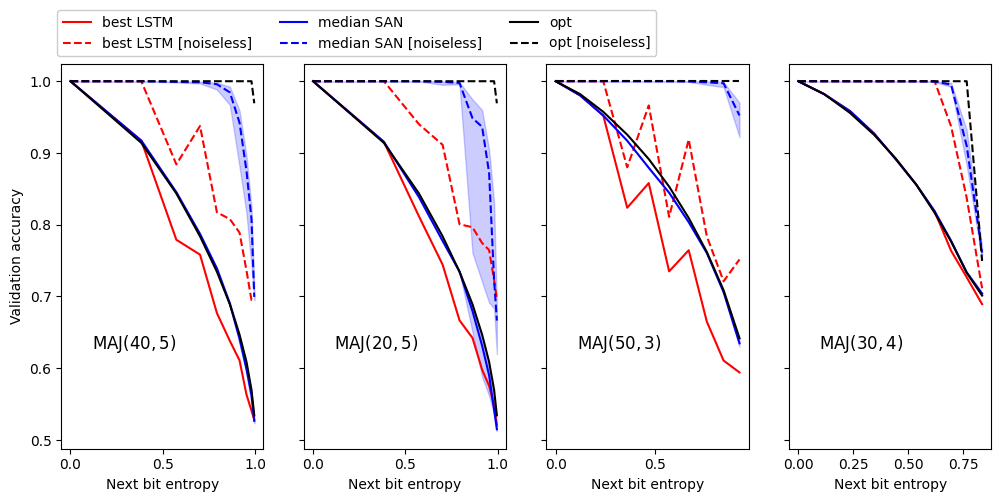

In [70]:

def append_last(x, y):
    return (x, y)
    # return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()



fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)


for j in range(len(SPREADSHEET_NAMES) - 1):
    ax = axes[j]
    # Read the CSV file into a DataFrame
    bf_vals = BF_VALS[j]
    df_all = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
    df_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")

    rnn_stats = np.zeros((len(bf_vals), 8)) # val_acc median, q1, q3, max_val_acc, noiseless_val_acc median, q1, q3, max_noiseless_val_acc
    san_stats = np.zeros((len(bf_vals), 8))

    stats_dct = {
        "RNN": rnn_stats,
        "SAN": san_stats
    }

    for k in stats_dct.keys():
        for i, bf in enumerate(bf_vals):
            df = df_all.loc[df_all["bf"] == bf].loc[df_all["model"] == k]
            stats_dct[k][i, 0] = df['val_acc'].median()
            stats_dct[k][i, 1] = df['val_acc'].quantile(0.35)
            stats_dct[k][i, 2] = df['val_acc'].quantile(0.85)
            stats_dct[k][i, 3] = df['val_acc'].max()
            stats_dct[k][i, 4] = df['noiseless_val_acc'].median()
            stats_dct[k][i, 5] = df['noiseless_val_acc'].quantile(0.33)
            stats_dct[k][i, 6] = df['noiseless_val_acc'].quantile(0.67)
            stats_dct[k][i, 7] = df['noiseless_val_acc'].max()


    
    xvals = df_ana["entropy"].values.flatten() # entropy x-axis
    # xvals = df_ana["bf"].values.flatten() # bitflip x-axis
    mle_noisy_final = df_ana["mle_noisy"].values.flatten()

    rnn_noisy = np.array(stats_dct["RNN"][:,3]).flatten()
    rnn_noiseless = np.array(stats_dct["RNN"][:,7]).flatten()
    san_noisy = np.array(stats_dct["SAN"][:,0]).flatten()
    san_noiseless = np.array(stats_dct["SAN"][:,4]).flatten()
    san_q1 = np.array(stats_dct["SAN"][:,1]).flatten()
    san_q3 = np.array(stats_dct["SAN"][:,2]).flatten()
    san_q1_noiseless = np.array(stats_dct["SAN"][:,5]).flatten()
    san_q3_noiseless = np.array(stats_dct["SAN"][:,6]).flatten()

    ax.plot(*append_last(xvals, rnn_noisy), label='best LSTM', c='r', ls='-')
    ax.plot(*append_last(xvals, rnn_noiseless), label='best LSTM [noiseless]', c='r', ls='--')

    ax.plot(*append_last(xvals, san_noisy), label='median SAN', c='b', ls='-')
    ax.plot(*append_last(xvals, san_noiseless), label='median SAN [noiseless]', c='b', ls='--')
    ax.fill_between(xvals, san_q1, san_q3, color='b', alpha=0.2)
    ax.fill_between(xvals, san_q1_noiseless, san_q3_noiseless, color='b', alpha=0.2)

    ax.plot(*append_last(xvals, mle_noisy_final), label='opt', c='k', ls='-')

    # get all_mle_noiseless values from df_ana
    all_mle_noiseless = df_ana["mle_noiseless"].values.flatten()
    ax.plot(*append_last(xvals, all_mle_noiseless), label='opt [noiseless]', c='k', ls='--')

    # ax.plot([0, 1, 1], [1, 1, 0.5], label='opt [noiseless]', c='k', ls='--')
    ax.set_xlabel('Next bit entropy')
    ax.text(0.15, 0.3, DATASET_NAMES[j], ha='left', va='top', fontsize=12, transform=ax.transAxes)

axes[0].set_ylabel('Validation accuracy')
axes[0].legend(prop={'size': 10}, framealpha=1, ncol=3, loc='lower left', bbox_to_anchor=(-0.02, 1.02), borderaxespad=0.)


            

The MAJ(30, 4) is actually a great transition piece for going from the $f = f_N^*$ functions to the $f \neq f_N^*$ functions

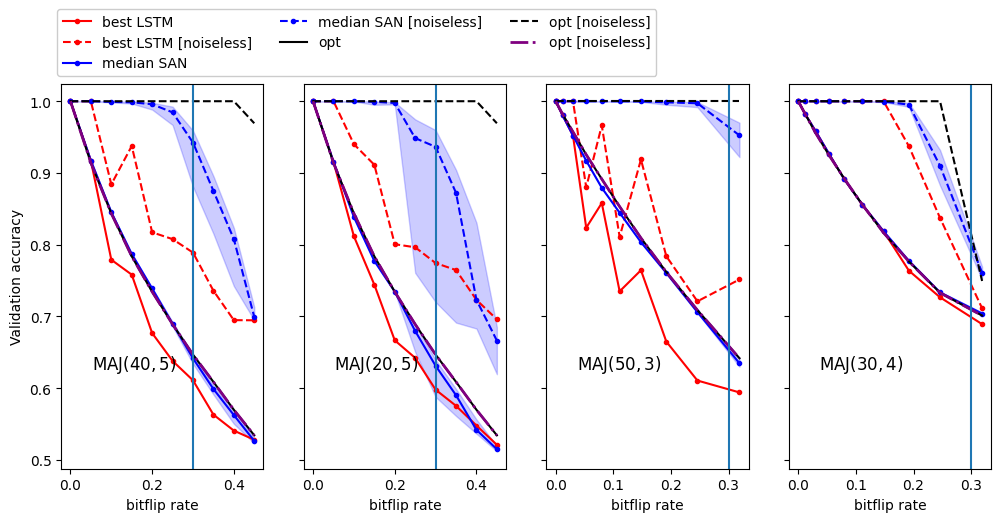

In [ ]:

def append_last(x, y):
    return (x, y)
    # return np.concatenate((x, [1])).flatten(), np.concatenate((y, [0.5])).flatten()



fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)


for j in range(len(SPREADSHEET_NAMES) - 1):
    ax = axes[j]
    # Read the CSV file into a DataFrame
    bf_vals = BF_VALS[j]
    df_all = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
    df_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")

    rnn_stats = np.zeros((len(bf_vals), 8)) # val_acc median, q1, q3, max_val_acc, noiseless_val_acc median, q1, q3, max_noiseless_val_acc
    san_stats = np.zeros((len(bf_vals), 8))

    stats_dct = {
        "RNN": rnn_stats,
        "SAN": san_stats
    }

    for k in stats_dct.keys():
        for i, bf in enumerate(bf_vals):
            df = df_all.loc[df_all["bf"] == bf].loc[df_all["model"] == k]
            stats_dct[k][i, 0] = df['val_acc'].median()
            stats_dct[k][i, 1] = df['val_acc'].quantile(0.35)
            stats_dct[k][i, 2] = df['val_acc'].quantile(0.85)
            stats_dct[k][i, 3] = df['val_acc'].max()
            stats_dct[k][i, 4] = df['noiseless_val_acc'].median()
            stats_dct[k][i, 5] = df['noiseless_val_acc'].quantile(0.33)
            stats_dct[k][i, 6] = df['noiseless_val_acc'].quantile(0.67)
            stats_dct[k][i, 7] = df['noiseless_val_acc'].max()

    # xvals = df_ana["entropy"].values.flatten() # entropy x-axis
    xvals = df_ana["bf"].values.flatten() # bitflip x-axis
    mle_noisy_final = df_ana["mle_noisy"].values.flatten()

    rnn_noisy = np.array(stats_dct["RNN"][:,3]).flatten()
    rnn_noiseless = np.array(stats_dct["RNN"][:,7]).flatten()
    san_noisy = np.array(stats_dct["SAN"][:,0]).flatten()
    san_noiseless = np.array(stats_dct["SAN"][:,4]).flatten()
    san_q1 = np.array(stats_dct["SAN"][:,1]).flatten()
    san_q3 = np.array(stats_dct["SAN"][:,2]).flatten()
    san_q1_noiseless = np.array(stats_dct["SAN"][:,5]).flatten()
    san_q3_noiseless = np.array(stats_dct["SAN"][:,6]).flatten()

    # plot but show the points at each values 
    ax.plot(*append_last(xvals, rnn_noisy), label='best LSTM', c='r', ls='-', marker='.')
    ax.plot(*append_last(xvals, rnn_noiseless), label='best LSTM [noiseless]', c='r', ls='--', marker='.')

    ax.plot(*append_last(xvals, san_noisy), label='median SAN', c='b', ls='-', marker='.')
    ax.plot(*append_last(xvals, san_noiseless), label='median SAN [noiseless]', c='b', ls='--', marker='.')
    ax.fill_between(xvals, san_q1, san_q3, color='b', alpha=0.2)
    ax.fill_between(xvals, san_q1_noiseless, san_q3_noiseless, color='b', alpha=0.2)

    ax.plot(*append_last(xvals, mle_noisy_final), label='opt', c='k', ls='-')
    # ax.plot([0, 0.5, 0.5], [1, 1, 0.5], label='opt [noiseless]', c='k', ls='--')
    all_mle_noiseless = df_ana["mle_noiseless"].values.flatten()
    ax.plot(*append_last(xvals, all_mle_noiseless), label='opt [noiseless]', c='k', ls='--')
    all_mle_noisy = df_ana["mle_noisy"].values.flatten()
    ax.plot(*append_last(xvals, all_mle_noisy), label='opt [noiseless]', c='purple', ls='-.', lw=2)

    ax.set_xlabel('bitflip rate')
    ax.text(0.15, 0.3, DATASET_NAMES[j], ha='left', va='top', fontsize=12, transform=ax.transAxes)
    ax.axvline(.30)

axes[0].set_ylabel('Validation accuracy')
axes[0].legend(prop={'size': 10}, framealpha=1, ncol=3, loc='lower left', bbox_to_anchor=(-0.02, 1.02), borderaxespad=0.)

#### Appendix material:
 - The same far-right bar plot but for the first two plots provided here.


### SPARITY data

- commentary on sparity(20, 4), e.g. bimodal distibution is a shitter to visualize.

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# New figure: do sparse parity
j = 4
bf_vals = BF_VALS[j]
df_sparity = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
df_sparity_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")
entropies = df_sparity_ana["entropy"].values.flatten()
for i, bf in enumerate(bf_vals):
    df1 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "RNN"]
    df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "SAN"]
    # entropies.append(entropy[0])
    # entropy = bf / 100
    mle_noiseless = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noiseless"].values.flatten()
    mle_noisy = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noisy"].values.flatten()

    epsilon = 0.01
    # compute fractions of models that achieved MLE performance
    ci = 80

    san_val_frac, san_val_bounds = bootstrap_fraction_in_range(df2['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    # san_noiseless_val_frac, san_noiseless_bounds = bootstrap_fraction_in_range(df2['noiseless_val_acc'].values, mle_noisy)
    rnn_val_frac, rnn_val_bounds = bootstrap_fraction_in_range(df1['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    # rnn_noiseless_val_frac, rnn_noiseless_val_bounds = bootstrap_fraction_in_range(df1['noiseless_val_acc'].values, mle_noiseless)
    
    width = 1
    axes[2].bar(i, san_val_frac, width=width, color='b', alpha=0.5, label=('SAN' if i == 0 else None), align='center', edgecolor='k', yerr=san_val_bounds)
    axes[2].bar(i, rnn_val_frac, width=width, color='r', alpha=0.5, label=('RNN' if i == 0 else None), align='center', edgecolor='k', yerr=rnn_val_bounds)
    # axes[1].bar(i, san_noiseless_val_frac, width=width, color='b', alpha=0.5, label='SAN [noiseless]', align='center', edgecolor='k')
    # axes[1].bar(i, rnn_noiseless_val_frac, width=width, color='r', alpha=0.5, label='RNN [noiseless]', align='center', edgecolor='k')


entropy_rounded = np.round(entropies, 2)
axes[2].set_xticks(range(len(bf_vals)), entropy_rounded, rotation=45, ha='right')
axes[2].set_xlabel('Next bit entropy')
axes[2].set_ylabel('Fraction of models achieving optimal')
axes[2].legend()
axes[2].text(0.75, 0.5, DATASET_NAMES[j], ha='center', va='top', fontsize=12, transform=axes[2].transAxes)

# save the figure
plt.savefig(f"./figures/fig1.pdf", dpi=300, bbox_inches='tight')

### Hamiltonian data

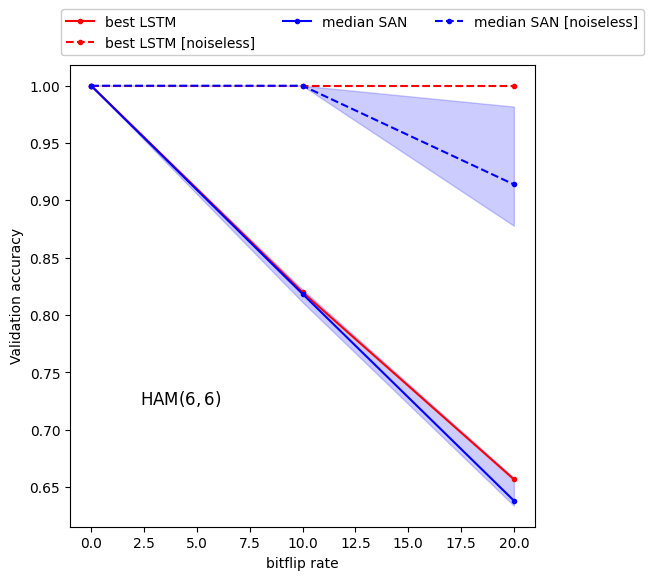

In [4]:
j = 5
bf_vals = BF_VALS[j]
df_hamilton = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
# df_hamilton_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

def append_last(x, y):
    return (x, y)

for df_all in [df_hamilton]:
    rnn_stats = np.zeros((len(bf_vals), 8)) # val_acc median, q1, q3, max_val_acc, noiseless_val_acc median, q1, q3, max_noiseless_val_acc
    san_stats = np.zeros((len(bf_vals), 8))

    stats_dct = {
        "RNN": rnn_stats,
        "SAN": san_stats
    }

    for k in stats_dct.keys():
        for i, bf in enumerate(bf_vals):
            df = df_all.loc[df_all["bf"] == bf].loc[df_all["model"] == k]
            stats_dct[k][i, 0] = df['val_acc'].median()
            stats_dct[k][i, 1] = df['val_acc'].quantile(0.35)
            stats_dct[k][i, 2] = df['val_acc'].quantile(0.85)
            stats_dct[k][i, 3] = df['val_acc'].max()
            stats_dct[k][i, 4] = df['noiseless_val_acc'].median()
            stats_dct[k][i, 5] = df['noiseless_val_acc'].quantile(0.33)
            stats_dct[k][i, 6] = df['noiseless_val_acc'].quantile(0.67)
            stats_dct[k][i, 7] = df['noiseless_val_acc'].max()

    xvals = bf_vals

    rnn_noisy = np.array(stats_dct["RNN"][:,3]).flatten()
    rnn_noiseless = np.array(stats_dct["RNN"][:,7]).flatten()
    san_noisy = np.array(stats_dct["SAN"][:,0]).flatten()
    san_noiseless = np.array(stats_dct["SAN"][:,4]).flatten()
    san_q1 = np.array(stats_dct["SAN"][:,1]).flatten()
    san_q3 = np.array(stats_dct["SAN"][:,2]).flatten()
    san_q1_noiseless = np.array(stats_dct["SAN"][:,5]).flatten()
    san_q3_noiseless = np.array(stats_dct["SAN"][:,6]).flatten()

    # plot but show the points at each values 
    ax.plot(*append_last(xvals, rnn_noisy), label='best LSTM', c='r', ls='-', marker='.')
    ax.plot(*append_last(xvals, rnn_noiseless), label='best LSTM [noiseless]', c='r', ls='--', marker='.')

    ax.plot(*append_last(xvals, san_noisy), label='median SAN', c='b', ls='-', marker='.')
    ax.plot(*append_last(xvals, san_noiseless), label='median SAN [noiseless]', c='b', ls='--', marker='.')
    ax.fill_between(xvals, san_q1, san_q3, color='b', alpha=0.2)
    ax.fill_between(xvals, san_q1_noiseless, san_q3_noiseless, color='b', alpha=0.2)


    ax.set_xlabel('bitflip rate')
    ax.text(0.15, 0.3, DATASET_NAMES[j], ha='left', va='top', fontsize=12, transform=ax.transAxes)

ax.set_ylabel('Validation accuracy')
ax.legend(prop={'size': 10}, framealpha=1, ncol=3, loc='lower left', bbox_to_anchor=(-0.02, 1.02), borderaxespad=0.)

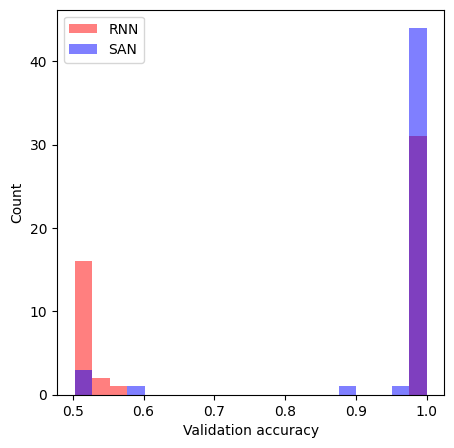

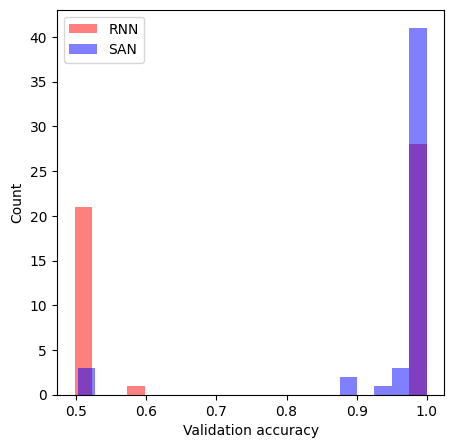

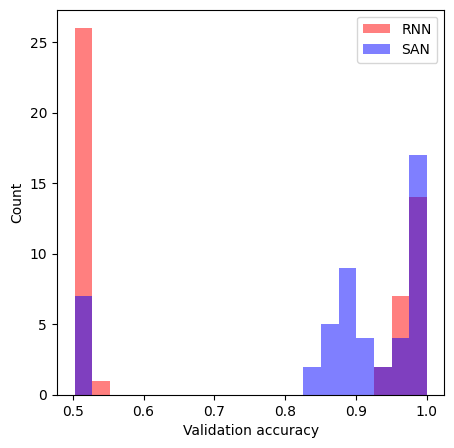

In [5]:
for bf in bf_vals:
    # plot a histogram of val acc for SAN and RNN
    df1 = df_hamilton.loc[df_hamilton["bf"] == bf].loc[df_hamilton["model"] == "RNN"]
    df2 = df_hamilton.loc[df_hamilton["bf"] == bf].loc[df_hamilton["model"] == "SAN"]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(df1["noiseless_val_acc"], bins=20, alpha=0.5, label='RNN', color='r')
    ax.hist(df2["noiseless_val_acc"], bins=20, alpha=0.5, label='SAN', color='b')
    ax.set_xlabel('Validation accuracy')
    ax.set_ylabel('Count')
    ax.legend()


[1.]
[0.84022]
[0.69114]


Text(0.75, 0.5, '$\\text{HAM}(6, 6)$')

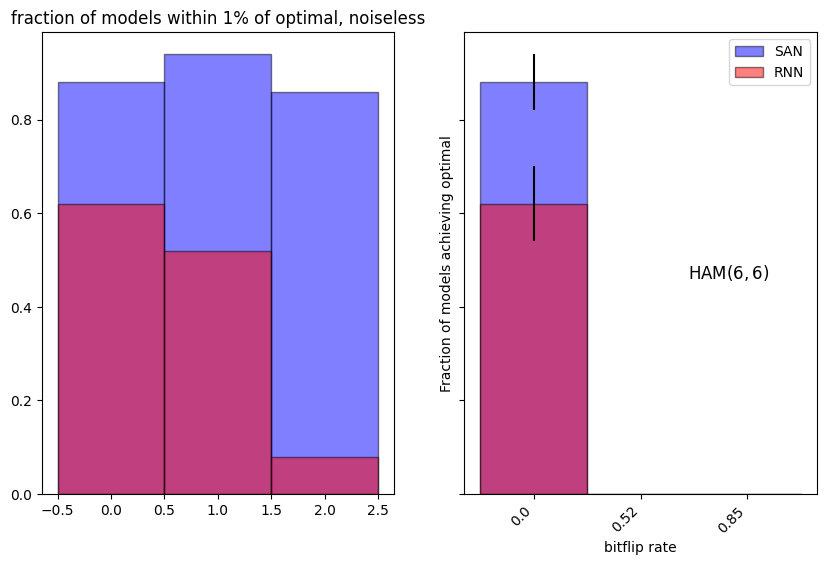

In [13]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# New figure: do hamilton
df_hamilton = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
df_hamilton_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")
entropies = df_hamilton_ana["entropy"].values.flatten()
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
for i, bf in enumerate(bf_vals):
    df1 = df_hamilton.loc[df_hamilton["bf"] == bf].loc[df_hamilton["model"] == "RNN"]
    df2 = df_hamilton.loc[df_hamilton["bf"] == bf].loc[df_hamilton["model"] == "SAN"]
    # entropies.append(entropy[0])
    # entropy = bf / 100
    mle_noiseless = df_hamilton_ana.loc[df_hamilton_ana["bf"] == bf/100]["mle_noiseless"].values.flatten()
    mle_noisy = df_hamilton_ana.loc[df_hamilton_ana["bf"] == bf/100]["mle_noisy"].values.flatten()
    print(mle_noisy)
    epsilon = 0.01
    # compute fractions of models that achieved MLE performance
    ci = 80
    san_val_frac, san_val_bounds = bootstrap_fraction_in_range(df2['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    san_noiseless_val_frac, san_noiseless_bounds = bootstrap_fraction_in_range(df2['noiseless_val_acc'].values, mle_noisy)
    rnn_val_frac, rnn_val_bounds = bootstrap_fraction_in_range(df1['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    rnn_noiseless_val_frac, rnn_noiseless_val_bounds = bootstrap_fraction_in_range(df1['noiseless_val_acc'].values, mle_noiseless)
    
    width = 1
    axes[1].bar(i, san_val_frac, width=width, color='b', alpha=0.5, label=('SAN' if i == 0 else None), align='center', edgecolor='k', yerr=san_val_bounds)
    axes[1].bar(i, rnn_val_frac, width=width, color='r', alpha=0.5, label=('RNN' if i == 0 else None), align='center', edgecolor='k', yerr=rnn_val_bounds)
    axes[0].bar(i, san_noiseless_val_frac, width=width, color='b', alpha=0.5, label='SAN [noiseless]', align='center', edgecolor='k')
    axes[0].bar(i, rnn_noiseless_val_frac, width=width, color='r', alpha=0.5, label='RNN [noiseless]', align='center', edgecolor='k')
    axes[0].set_title("fraction of models within 1% of optimal, noiseless")


entropy_rounded = np.round(entropies, 2)
axes[1].set_xticks(range(len(bf_vals)), entropy_rounded, rotation=45, ha='right')
axes[1].set_xlabel('bitflip rate')
axes[1].set_ylabel('Fraction of models achieving optimal')
axes[1].legend()
axes[1].text(0.75, 0.5, DATASET_NAMES[j], ha='center', va='top', fontsize=12, transform=axes[1].transAxes)

# save the figure
# plt.savefig(f"./figures/fig1.pdf", dpi=300, bbox_inches='tight')

In [12]:

for column_name in ["lr", "depth", "hidden_size", "emb_size"]:
    print(df_hamilton[column_name].unique())

[2.2516e-02 3.4600e-04 1.5100e-04 5.1794e-02 2.7778e-01 1.4842e-02
 4.2290e-03 1.0000e-04 1.8197e-01 2.2900e-04 1.2060e-03 7.8804e-02
 3.4183e-02 1.8320e-03 9.7740e-03 6.4280e-03 7.9600e-04 1.1943e-01
 2.7820e-03 3.9810e-03 4.0000e-05 1.0000e-02 6.3100e-02 1.5850e-03
 1.6000e-05 1.0000e-05 3.9800e-04 2.5100e-04 1.0000e-03 2.5120e-03
 1.5800e-04 6.3100e-04 3.9810e-02 2.5000e-05 6.3000e-05 6.3100e-03
 1.5850e-02]
[6 4 2 5 1 3]
[128.  32.  16.  64.  nan]
[ 64.  32. 128.  16.  nan]


In [94]:
df_hamilton["lr"].unique()

array([2.2516e-02, 3.4600e-04, 1.5100e-04, 5.1794e-02, 2.7778e-01,
       1.4842e-02, 4.2290e-03, 1.0000e-04, 1.8197e-01, 2.2900e-04,
       1.2060e-03, 7.8804e-02, 3.4183e-02, 1.8320e-03, 9.7740e-03,
       6.4280e-03, 7.9600e-04, 1.1943e-01, 2.7820e-03, 3.9810e-03,
       4.0000e-05, 1.0000e-02, 6.3100e-02, 1.5850e-03, 1.6000e-05,
       1.0000e-05, 3.9800e-04, 2.5100e-04, 1.0000e-03, 2.5120e-03,
       1.5800e-04, 6.3100e-04, 3.9810e-02, 2.5000e-05, 6.3000e-05,
       6.3100e-03, 1.5850e-02])

In [96]:
df_hamilton.head()

,epoch,train_loss,train_acc,val_acc,noiseless_val_acc,final_train_acc,final_val_acc,final_noiseless_val_acc,sensitivity,lr,emb_size,hidden_size,dropout,depth,cell_type,bf,model,d_model,heads,d_ffn
0,5,0.716056,0.538217,0.532947,0.532947,0.490048,0.497604,0.497604,NaN,0.022516,64.0,128.0,0.10,6,LSTM,0,RNN,NaN,NaN,NaN
1,12,0.062634,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000346,32.0,32.0,0.10,4,LSTM,0,RNN,NaN,NaN,NaN
2,27,0.100794,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000151,128.0,16.0,0.10,2,LSTM,0,RNN,NaN,NaN,NaN
3,7,0.767252,0.509952,0.502396,0.502396,0.490048,0.497604,0.497604,NaN,0.051794,32.0,128.0,0.10,5,LSTM,0,RNN,NaN,NaN,NaN
4,135,0.701810,0.509952,0.502396,0.502396,0.490048,0.497604,0.497604,NaN,0.277780,128.0,16.0,0.05,4,LSTM,0,RNN,NaN,NaN,NaN


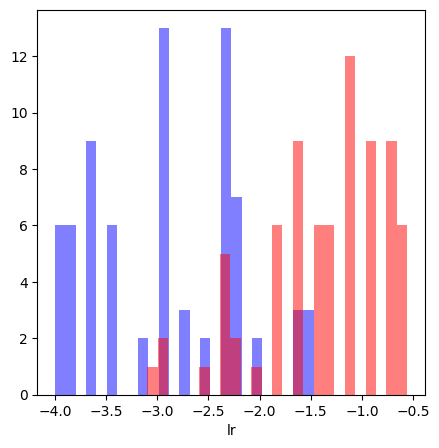

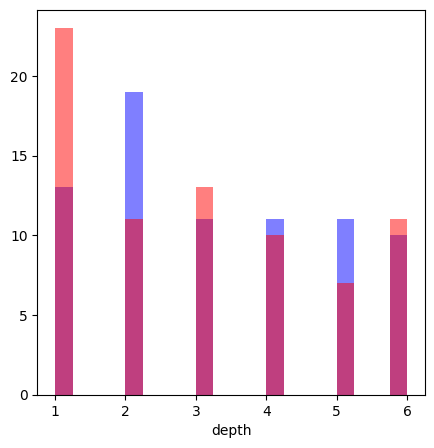

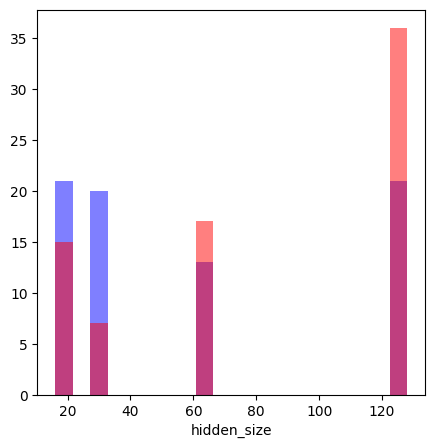

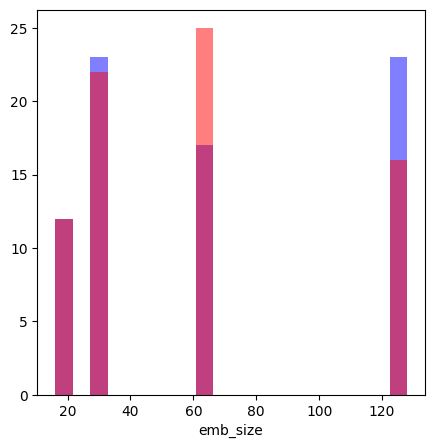

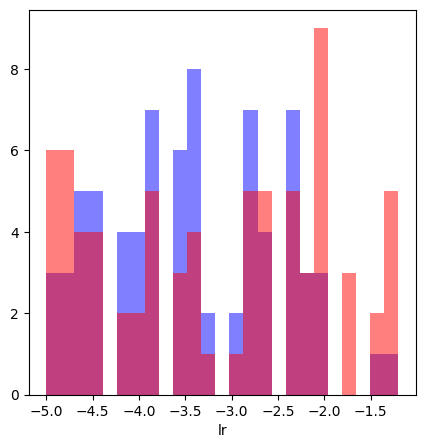

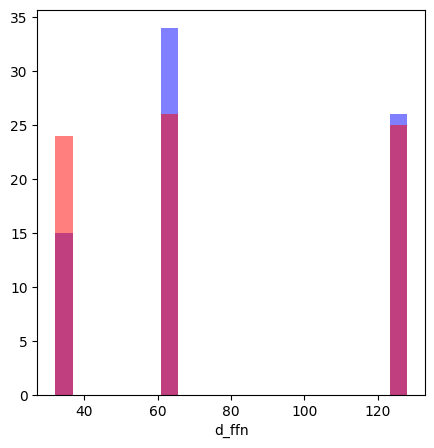

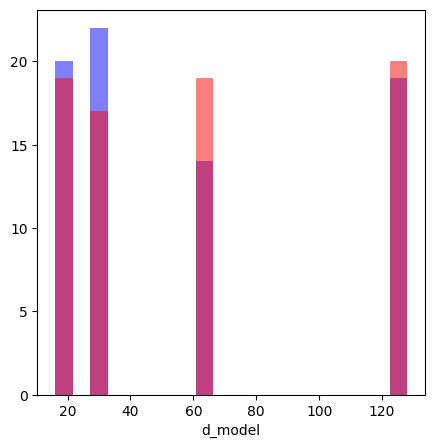

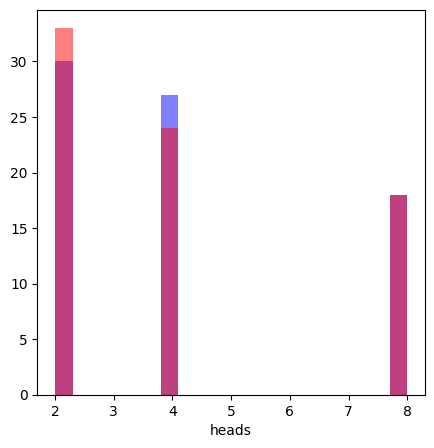

In [105]:
def plot_hist_by_column(df, column_name, cutoff_name, quantile):
    # create a histogram of df[column_name] split into two groups:
    # the first group is the top quantile of df[cutoff_name]
    cutoff_val = df[cutoff_name].quantile(quantile)
    df1 = df[df[cutoff_name] > cutoff_val]
    df2 = df[df[cutoff_name] <= cutoff_val]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    if column_name == "lr":
        ax.hist(np.log10(df1[column_name]), bins=25, alpha=0.5, label='top quantile', color='b')
        ax.hist(np.log10(df2[column_name]), bins=25, alpha=0.5, label='bottom quantile', color='r')
    else:
        ax.hist(df1[column_name], bins=20, alpha=0.5, label='top quantile', color='b')
        ax.hist(df2[column_name], bins=20, alpha=0.5, label='bottom quantile', color='r')
    ax.set_xlabel(column_name)

    plt.show()

for column_name in ["lr", "depth", "hidden_size", "emb_size"]:
    plot_hist_by_column(df_hamilton[df_hamilton["model"] == "RNN"], column_name, "val_acc", 0.5)

for column_name in ["lr", "d_ffn", "d_model", "heads"]:
    plot_hist_by_column(df_hamilton[df_hamilton["model"] == "SAN"], column_name, "val_acc", 0.5)


In [ ]:

name = "sparse_majority_21_5"
sheetname1 = "RNN_sparse_majority_k5_nbits21_n2000_bf10_seed1234"
sheetname2 = "RNN_sparse_majority_k5_nbits21_n2000_bf10.0_seed1234_results"
# load these two things
spreadsheet = client.open(name)
sheet1 = spreadsheet.worksheet(sheetname1)
sheet2 = spreadsheet.worksheet(sheetname2)
data1 = sheet1.get_all_records()
data2 = sheet2.get_all_records()
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

In [25]:

name = "sparse_parity_21_4"
sheetname1 = "RNN_sparse_parity_k4_nbits21_n5000_bf0_seed1234"
# sheetname2 = "RNN_sparse_parity_k5_nbits21_n2000_bf10.0_seed1234_results"
# load these two things
spreadsheet = client.open(name)
sheet1 = spreadsheet.worksheet(sheetname1)
data1 = sheet1.get_all_records()
df1 = pd.DataFrame(data1)


c:\Users\peter\Desktop\projects\MindReadingAutobot\.venv\Lib\site-packages\numpy\lib\_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


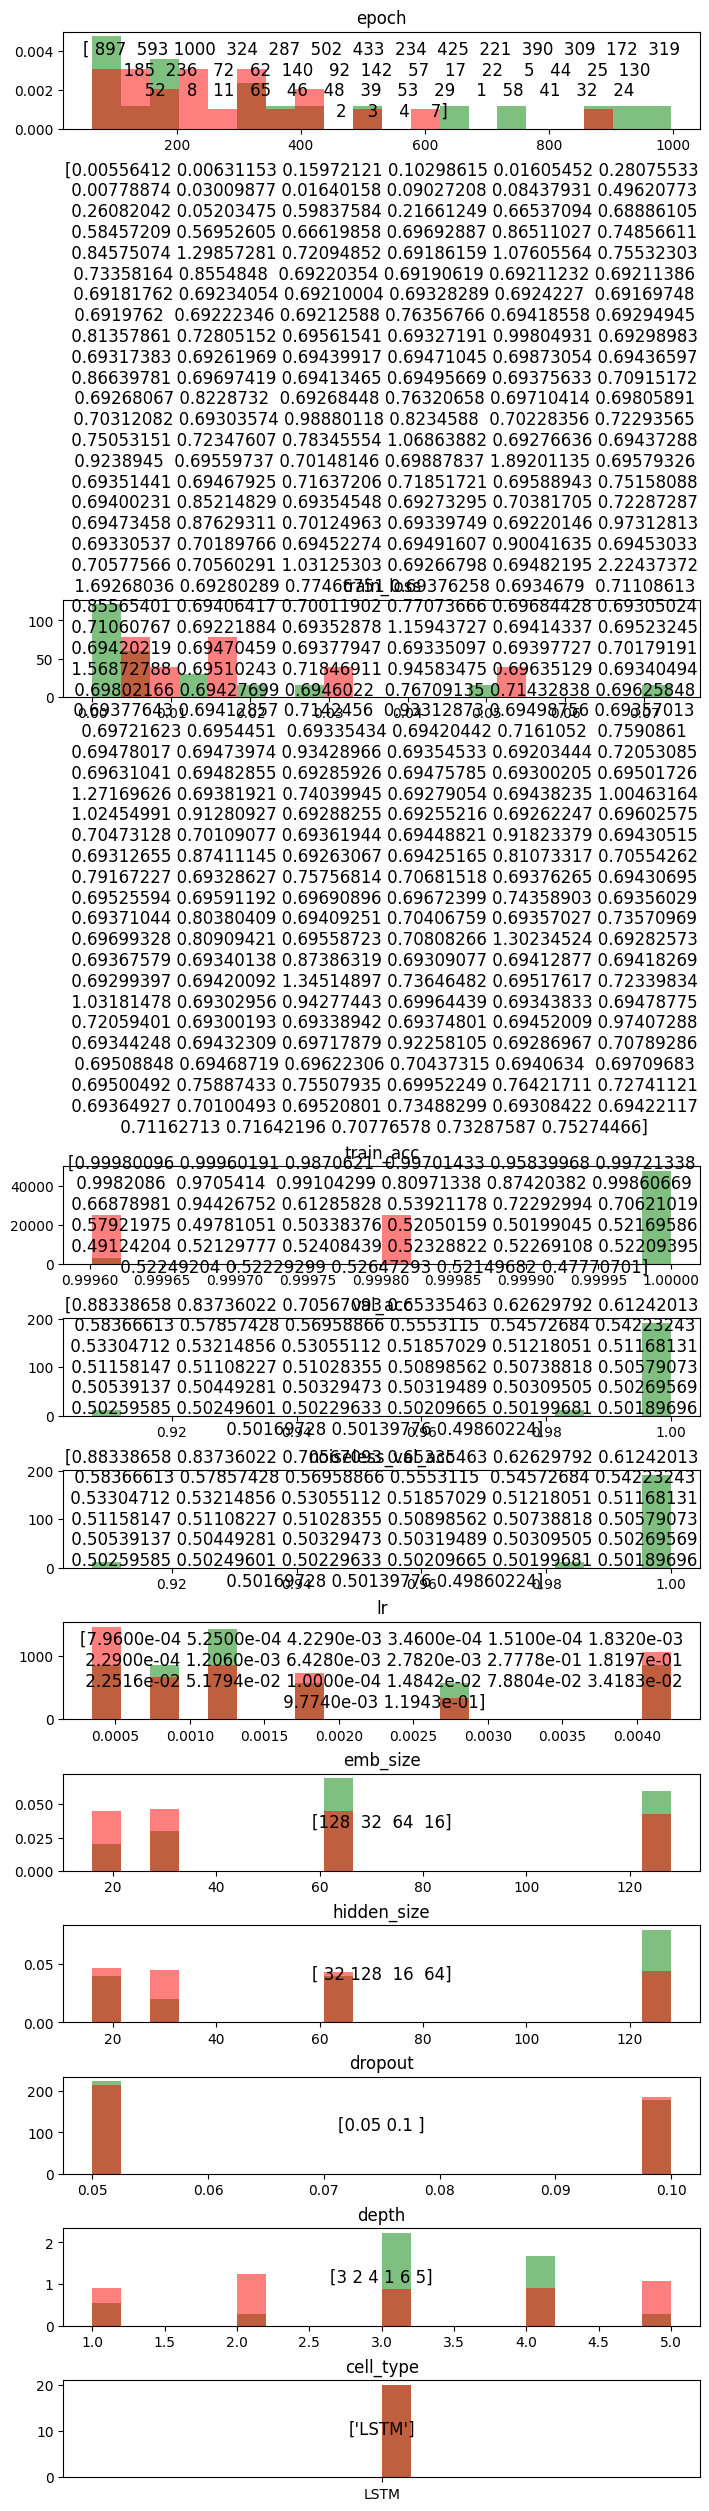

In [31]:
good = df1[df1["noiseless_val_acc"] > 0.9]
bad = df1[df1["noiseless_val_acc"] < 0.9]

n_columns = len(df1.columns)
fig, axes = plt.subplots(n_columns, 1, figsize=(7, 25), constrained_layout=True)
for col in range(n_columns):
    # get the column name
    col_name = df1.columns[col]
    # plot the good and bad data
    cts, bins, _ = axes[col].hist(good[col_name], bins=20, alpha=0.5, label='good', color='g', density=True)
    axes[col].hist(bad[col_name], bins=bins, alpha=0.5, label='bad', color='r', density=True)
    axes[col].set_title(col_name)
    axes[col].text(0.5, 0.5, bad[col_name].unique(), ha='center', va='center', fontsize=12, transform=axes[col].transAxes)
    # axes[col].legend()

In [ ]:
array([3.000e-04, 5.000e-04, 8.000e-04, 1.200e-03, 1.800e-03, 2.800e-03, 4.200e-03, 6.400e-03, 9.800e-03])

In [37]:
display(np.round(np.array(list(sorted(bad["lr"].unique()))), 4))

array([1.000e-04, 2.000e-04, 2.000e-04, 3.000e-04, 5.000e-04, 8.000e-04,
       1.200e-03, 1.800e-03, 2.800e-03, 4.200e-03, 6.400e-03, 9.800e-03,
       1.480e-02, 2.250e-02, 3.420e-02, 5.180e-02, 7.880e-02, 1.194e-01,
       1.820e-01, 2.778e-01])

[]

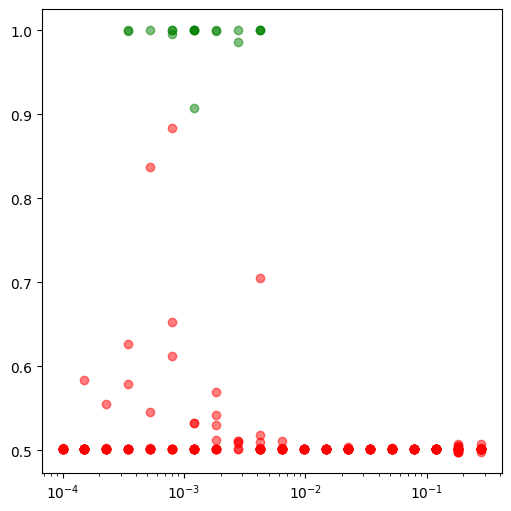

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)

ax.scatter(good["lr"], good["val_acc"], c='g', alpha=0.5, label='good')
ax.scatter(bad["lr"], bad["val_acc"], c='r', alpha=0.5, label='bad')
ax.semilogx()
